In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import tifffile as tfl
import h5py
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm_notebook
%matplotlib inline

In [19]:
os.chdir('D:/Landslide')

In [20]:
%ls

 Volume in drive D is Remote Sensing and GIS data
 Volume Serial Number is 78A5-4D3B

 Directory of D:\Landslide

04/18/2022  05:55 PM    <DIR>          .
04/18/2022  05:55 PM    <DIR>          ..
04/18/2022  10:37 AM                38 .gitignore
04/18/2022  10:27 AM    <DIR>          .ipynb_checkpoints
04/18/2022  09:09 AM         1,324,307 0.EDA for Landslide4Sense.ipynb
04/18/2022  05:55 PM           927,338 1. Data Loader.ipynb
04/18/2022  10:27 AM         1,606,568 2.Slope_and_Aspect_Map_reading.ipynb
04/18/2022  10:25 AM           711,093 3.U_net & Deep U_net Model.ipynb
04/18/2022  11:13 AM           297,816 Mapping landslides from EO data using deep-learning methods.pdf
04/18/2022  05:53 PM    <DIR>          npy_data
04/17/2022  09:22 PM    <DIR>          Sample
04/17/2022  05:36 PM    <DIR>          TrainData
04/14/2022  08:06 PM     2,442,381,619 TrainData.zip
04/18/2022  11:15 AM         4,858,605 U-Net and ResU-Net.pdf
               8 File(s)  2,452,107,384 bytes
         

In [21]:
folder_list = sorted(os.listdir('D:/Landslide/TrainData/img'))
mask_folder_list =sorted(os.listdir(r'D:/Landslide/TrainData/mask'))
#mask_folder_list.remove('collection.json')

# train_dir = '../input/severstal-steel-defect-detection/' # directory of training images


In [22]:
print(f'Image name is {folder_list[110]}')
print(f'Mask name is {mask_folder_list[110]}')
print(f'Number of items in Folder List {len(folder_list)}')
print(f'Number of items in mask list {len(mask_folder_list)}')

Image name is image_1099.h5
Mask name is mask_1099.h5
Number of items in Folder List 3798
Number of items in mask list 3798


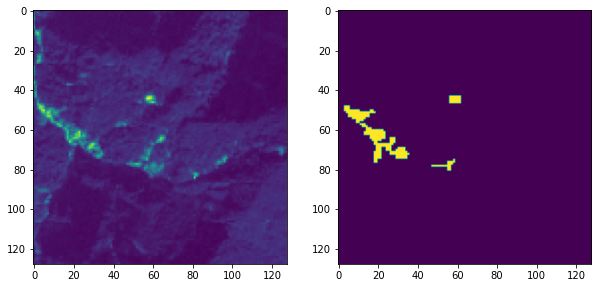

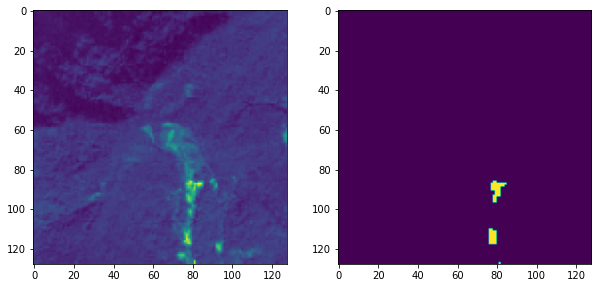

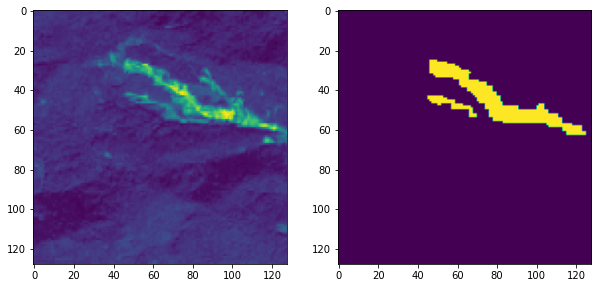

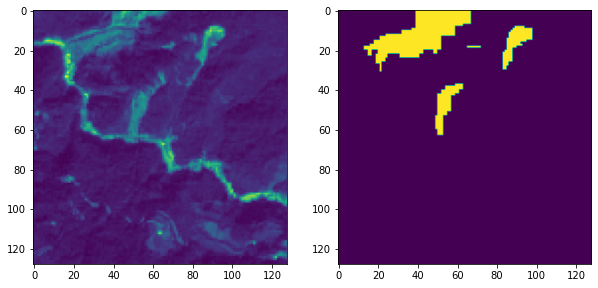

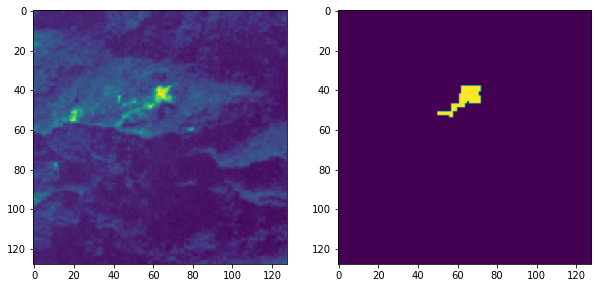

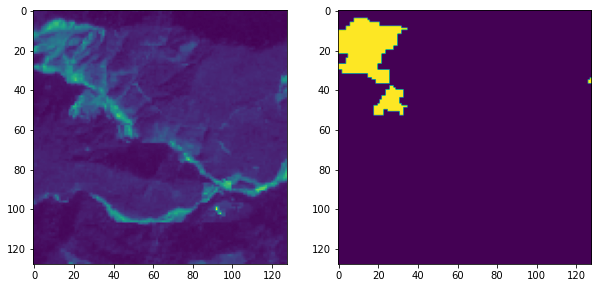

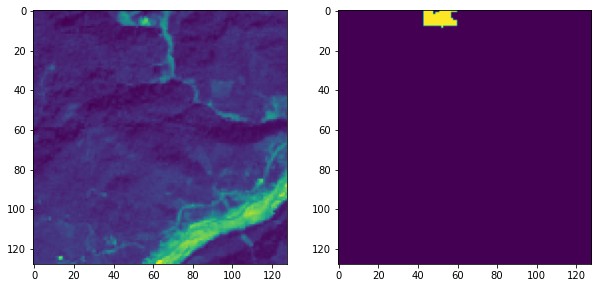

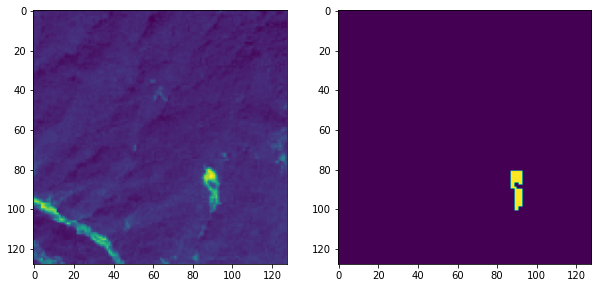

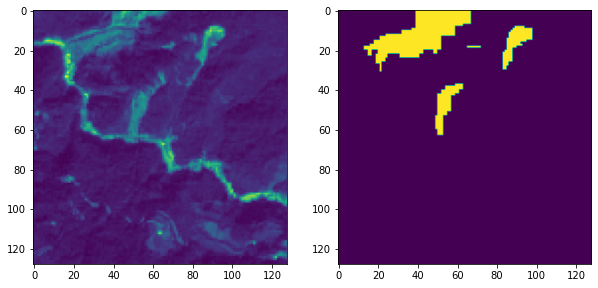

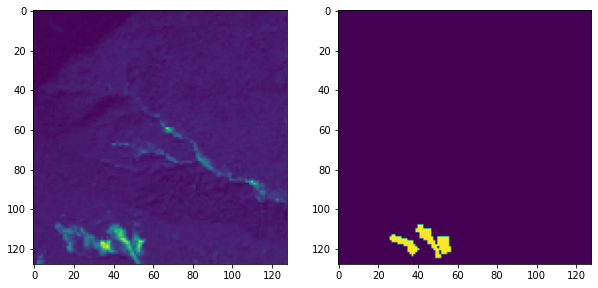

In [23]:
# # Dataloader for Pytorch
dataset_dir='D:/Landslide/TrainData/img/'
mask_dir='D:/Landslide/TrainData/mask/'

class data_loader():
    def __init__(self,dataset_dir,mask_dir):
        self.dataset_dir = dataset_dir
        self.mask_dir = mask_dir
        
        folder_list = os.listdir(self.dataset_dir)
        mask_folder_list = os.listdir(self.mask_dir)

    def __getitem__(self,idx):
        image = self.get_image(folder_list[idx])
        mask = self.get_mask_image(mask_folder_list[idx])
    
        return image,mask
    
    def get_image(self,folder_dir):
        image = h5py.File(dataset_dir+folder_dir,'r')
        image = np.array(image.get('img'))
        
#         image = tfl.imread(dataset_dir+folder_dir)
    
        return image
    
    def get_mask_image(self,folder_dir):
        image = h5py.File(mask_dir+folder_dir,'r')
        image = np.array(image.get('mask'))
#         label = np.array(Image.open(mask_dir+folder_dir+'/labels.tif'))
        
        return image
    
training_data = data_loader(dataset_dir,mask_dir)

for i in range(10):
    n = np.random.randint(1,100)
    fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
    ax1.imshow(training_data[n][0][:,:,1])
    ax2.imshow(training_data[n][1])

In [39]:
len(training_data[0][0]),len(sat_data1[0][0])

(128, 100)

# Tensorflow DataLoader

In [34]:

dataset_dir='D:/Landslide/TrainData/img/'
mask_dir='D:/Landslide/TrainData/mask/'

class data_loader(keras.utils.Sequence):
    def __init__(self, batch_size, img_size,num_classes,dataset_dir,mask_dir):
        self.batch_size = batch_size
        self.img_size = img_size
        self.dataset_dir = dataset_dir
        self.mask_dir = mask_dir
        self.num_classes= num_classes
        self.folder_list = sorted(os.listdir(self.dataset_dir))
        self.mask_folder_list = sorted(os.listdir(self.mask_dir))


    def __len__(self):
        return len(self.folder_list)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.folder_list[i : i + self.batch_size]
        batch_target_img_paths = self.mask_folder_list[i : i + self.batch_size]

        # load images
        x = np.zeros((self.batch_size,) + self.img_size + (6,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = self.get_image(self.dataset_dir+path)
            x[j] = img

        # load masks
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = self.get_mask_image(self.mask_dir+path)
            y[j] = img  

        return x,y



    def get_image(self,folder_dir):
        image = h5py.File(folder_dir,'r')
        image = np.array(image.get('img'))
        data1 = image[:,:,1] #Band 2
        data2 = image[:,:,2] #Band 3
        data3 = image[:,:,3] #Band 4
        data4 = image[:,:,7] #Band 8
        data5 = image[:,:,13] # DEM data
        data5 = rd.rdarray(data5,no_data= -99999) #Reading DEM data with rdarray
        aspect = rd.TerrainAttribute(data5,attrib='aspect'); # Calculating Aspect
        curvature = rd.TerrainAttribute(data5, attrib='profile_curvature'); # Calculating Curvature
        image = np.moveaxis(np.stack((data1,data2,data3,data4,aspect,curvature)),0,2)
        
        return image
    
    def get_mask_image(self,folder_dir):
        image = h5py.File(folder_dir,'r')
        image = np.array(image.get('mask'))

        
        return image

In [35]:
sat_data1 = data_loader(100,(128,128),14,dataset_dir,mask_dir)
val_gen = data_loader(10,(128,128),14,dataset_dir,mask_dir)

In [ ]:
len(sat_data1),len(val_gen)

In [ ]:
x,y = val_gen[0]
print(x.shape)
print(y.shape)
for i in range(10):
    n = np.random.randint(1,2)
    fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
    # ax1.imshow(x[n][0][:,:,1])
    ax1.imshow(x[n][:,:,1])
    ax2.imshow(y[n])

In [ ]:
x,y = sat_data1[3]
print(x.shape)
print(y.shape)
for i in range(10):
    n = np.random.randint(1,10)
    fig,(ax1,ax2)= plt.subplots(1,2,figsize=(10,10))
    # ax1.imshow(x[n][0][:,:,1])
    ax1.imshow(x[n][:,:,1])
    ax2.imshow(y[n])